# Fastscapelib "user flow kernels" prototype

In [1]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np

from fastscapelib.flow import numba_kernel
import fastscapelib as fs

from fastscapelib.flow import py_apply_kernel, NumbaFlowKernel

grid = fs.RasterGrid.from_length([201, 301], [5e4, 7.5e4], fs.NodeStatus.FIXED_VALUE)
flow_graph = fs.FlowGraph(grid, [fs.SingleFlowRouter(), fs.MSTSinkResolver()])

rng = np.random.Generator(np.random.PCG64(1234))

init_elevation = rng.uniform(0, 5, size=grid.shape)
drainage_area = np.empty_like(init_elevation)

uplift_rate = np.full_like(init_elevation, 1e-3)
uplift_rate[[0, -1], :] = 0.0
uplift_rate[:, [0, -1]] = 0.0
flow_graph.update_routes(init_elevation)


def kernel_func(node):
    dt = node.dt
    r_count = node.receivers.count
    if r_count == 1 and node.receivers.distance[0] == 0.0:
        return

    elevation_flooded = np.finfo(np.double).max

    for r in range(r_count):
        irec_elevation_next = node.receivers.elevation[r] - node.receivers.erosion[r]

        if irec_elevation_next < elevation_flooded:
            elevation_flooded = irec_elevation_next

    if node.elevation <= elevation_flooded:
        return

    eq_num = node.elevation
    eq_den = 1.0

    for r in range(r_count):
        irec_elevation = node.receivers.elevation[r]
        irec_elevation_next = irec_elevation - node.receivers.erosion[r]

        if irec_elevation > node.elevation:
            continue

        irec_weight = node.receivers.weight[r]
        irec_distance = node.receivers.distance[r]

        factor = (
            node.k_coef * dt * np.power(node.drainage_area * irec_weight, node.area_exp)
        )
        factor /= irec_distance
        eq_num += factor * irec_elevation_next
        eq_den += factor

    elevation_updated = eq_num / eq_den

    if elevation_updated < elevation_flooded:
        elevation_updated = elevation_flooded + np.finfo(np.double).tiny

    node.erosion = node.elevation - elevation_updated

elevation = init_elevation.ravel().copy()
erosion = np.zeros(flow_graph.size)
drainage_area = np.ones(flow_graph.size)

In [2]:
kernel = NumbaFlowKernel(
    flow_graph,
    kernel_func,
    spec=[
        ("elevation", nb.float64[::1]),
        ("erosion", nb.float64[::1]),
        ("drainage_area", nb.float64[::1]),
        ("k_coef", 2e-4),
        ("area_exp", 0.4),
        ("slope_exp", 1.),
        ("dt", 2e4),
    ],
    outputs=["erosion"],
    max_receivers=1,
    n_threads=1,
    application_order=fs.flow.KernelApplicationOrder.BREADTH_UPSTREAM
)

kernel.bind_data(
    elevation=elevation,
    erosion=erosion,
    drainage_area=drainage_area
)
flow_graph.apply_kernel(kernel, kernel.kernel_data)

import time
N_TIMES = 1

t1 = time.time()
for _ in range(N_TIMES):
    flow_graph.apply_kernel(kernel, kernel.kernel_data)
print(round((time.time() - t1) * 1e9 / N_TIMES / grid.size, 1))

py_apply_kernel(kernel, kernel.kernel_data)
t1 = time.time()
for _ in range(N_TIMES):
    py_apply_kernel(kernel, kernel.kernel_data)
print(round((time.time() - t1) * 1e9 / N_TIMES / grid.size, 1))

26.8
25.6


In [3]:
flow_graph.apply_kernel(kernel, kernel.kernel_data)

0

In [4]:
dt = 2e4
nsteps = 50
uplift = dt * uplift_rate.ravel()


# kernel.update_grid_data({
#                     "elevation": elevation,
#                     "erosion": erosion,
#                     "drainage_area": drainage_area})

def run_simulation():
    global elevation

    current_elevation = init_elevation.ravel().copy()

    for step in range(nsteps):

        # kernel._grid_data["foo"] = np.ones(flow_graph.size)
        # uplift (no uplift at fixed elevation boundaries)
        elevation[:] = current_elevation + uplift

        # flow routing
        flow_graph.update_routes(elevation)

        # flow accumulation (drainage area)
        flow_graph.accumulate(drainage_area, 1.0)

        # apply channel erosion (SPL)
        # kernel.erode(elevation, 
        #              {
        #             "elevation": elevation,
        #             "erosion": erosion,
        #             "drainage_area": drainage_area},
        #              dt)
        erosion.fill(0.)
        flow_graph.apply_kernel(kernel, kernel.kernel_data)
        # flow_graph.apply_kernel(kernel2, drainage_area, dt)
        # flow_graph.apply_kernel(kernel3, drainage_area, dt)

        # update topography
        current_elevation = elevation - erosion

    return current_elevation

In [5]:
for i in [1, 2, 4, 8, 16]:
    kernel.kernel.n_threads = i
    %timeit -r 10 -n 10  flow_graph.apply_kernel(kernel, kernel.kernel_data)

1.51 ms ± 25.4 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
2.35 ms ± 16.7 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
2.45 ms ± 12.3 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
2.72 ms ± 19.7 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
5.26 ms ± 42.7 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [6]:
for i in [1, 2, 4, 8, 16]:
    kernel.kernel.n_threads = i
    %timeit -r 1 -n 1 run_simulation()

464 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
517 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
491 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
491 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
540 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
# efficiency of the parallel execution depends to the kernel size, the current flow graph and the kernel execution order
for i in [1, 2, 4, 8, 16]:
    kernel.kernel.n_threads = i
    %timeit -r 10 -n 10  flow_graph.apply_kernel(kernel, kernel.kernel_data)

1.93 ms ± 29.3 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
1.79 ms ± 33 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
1.28 ms ± 11.9 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
1.09 ms ± 13.4 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
1.74 ms ± 34.7 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Fastscapelib Python bindings

In [8]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np

import fastscapelib as fs

uplift_rate = np.full_like(init_elevation, 1e-3)
uplift_rate[[0, -1], :] = 0.
uplift_rate[:, [0, -1]] = 0.

dt = 2e4
nsteps = 50

k_coef = 2e-4
area_exp = 0.4
slope_exp = 1

flow_graph.update_routes(init_elevation)

spl_eroder = fs.SPLEroder(
    flow_graph,
    k_coef=k_coef,
    area_exp=area_exp,
    slope_exp=slope_exp,
    tolerance=1e-5,
)
def run_simulation2():
    elevation = init_elevation.copy()
    drainage_area = np.empty_like(init_elevation)

    for step in range(nsteps):
        # uplift (no uplift at fixed elevation boundaries)
        uplifted_elevation = elevation + dt * uplift_rate
        
        # flow routing
        filled_elevation = flow_graph.update_routes(uplifted_elevation)
        
        # flow accumulation (drainage area)
        flow_graph.accumulate(drainage_area, 1.0)
        
        # apply channel erosion (SPL)
        spl_erosion = spl_eroder.erode(uplifted_elevation, drainage_area, dt)

        # update topography
        elevation = uplifted_elevation - spl_erosion

    return elevation   

In [9]:
%timeit -r 1 -n 1 run_simulation2()

457 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%timeit -r 10 -n 10 spl_eroder.erode(elevation, drainage_area, dt)

1.66 ms ± 32.7 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Benchmark Results

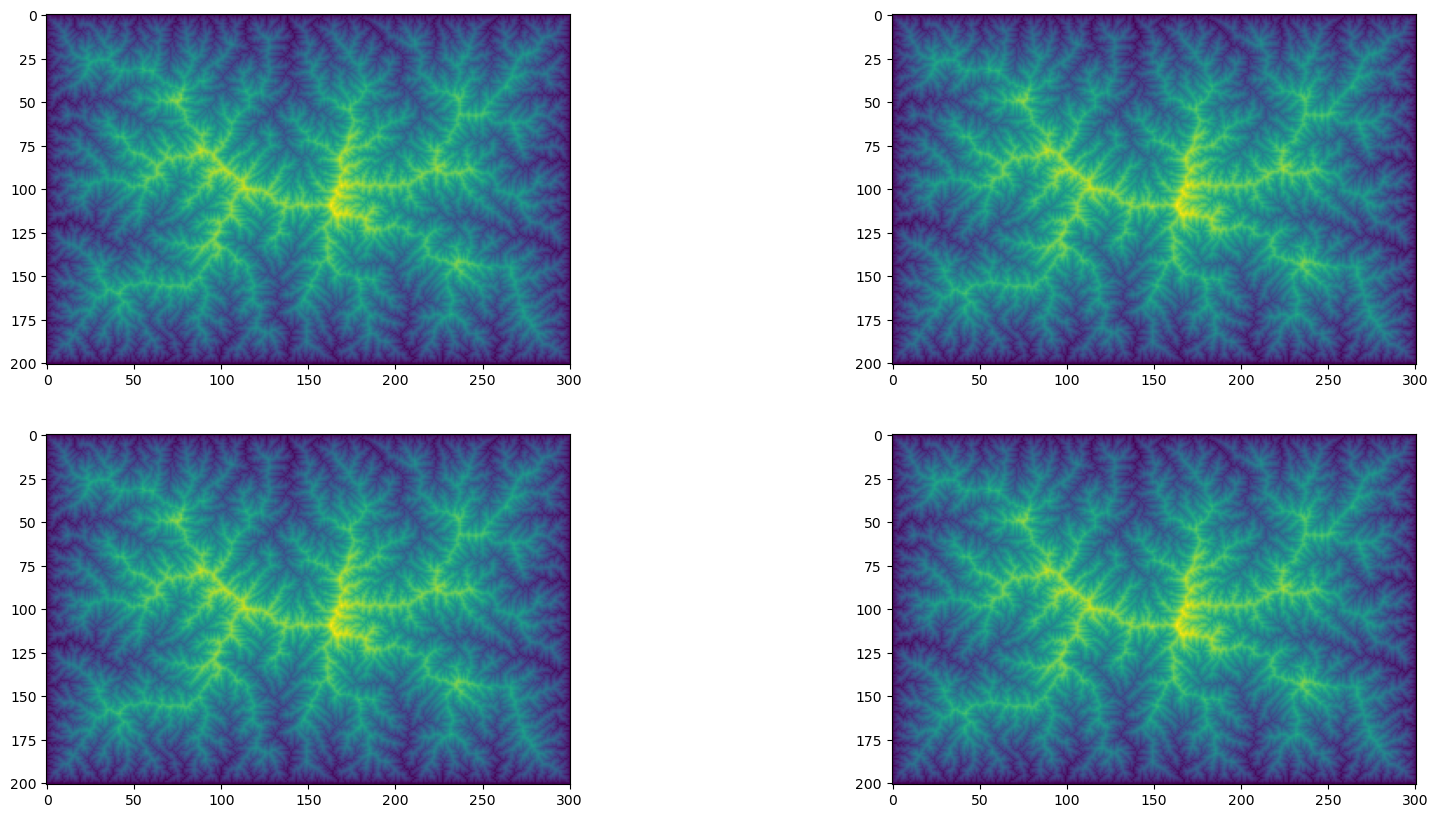

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

kernel.kernel.n_threads = 1
axes[0, 0].imshow(run_simulation().reshape(grid.shape))
kernel.kernel.n_threads = 4
axes[0, 1].imshow(run_simulation().reshape(grid.shape))
kernel.kernel.n_threads = 8
axes[1, 0].imshow(run_simulation().reshape(grid.shape))

axes[1, 1].imshow(run_simulation2());

In [ ]:


# class EroderKernelBase:
#     def __init__(self, flow_graph):
#         self._flow_graph = flow_graph
#         self._kernel = ....

#     @property
#     def grid_data_names(self):
#         raise NotImplementedError()

#     @property
#     def constants_names:
#         raise NotImplementedError()

#     def erode(self):
#         self._flow_graph.apply_kernel(self._kernel)


# class SplEroderKernel(EroderKernelBase):

#     threads_count = 1
#     application_order = fs.flow.KernelApplicationOrder.BREADTH_UPSTREAM
    
#     """fazedfza"""
#     elevation = np.ones(flow_graph.size)
    
#     def __init__(self, flow_graph, k_coeff, area_exp, slope_exp):
#         """

#         params
#         ------
#         k_coeff: 

        
#         """
#         super().__init__(flow_graph)
   
#     @property
#     def grid_data_names(self):
#         return []

#     @property
#     def constants_names:
#         return []

#     def erode(self, **kwargs, dt):
#         erosion.fill(0.)
#         self._kernel.update_data(**kwargs)
        
#         super().erode()

# kernel = NumbaFlowKernel(...)
# kernel_data = NumbaFlowKernelData(kernel, data={})

# apply_kernel(kernel, kernel_data)
# data = kernel._data( 
#         elevation=elevation,
#         erosion=erosion,
#         drainage_area=drainage_area,
#         foo=np.zeros(flow_graph.size),
#         bar=nb.float64[::1])

# flow_graph.apply_kernel(kernel, data)
# flow_graph.apply_kernel(kernel, erosion=np.zeros(flow_graph.size), elevation = )
# flow_graph.apply_kernel(kernel, data)